# 🌤 Weather Temperature
Nikos Kordalis

### Libraries

* Let's import the usual libraries:

In [ ]:
# Data manipulation
import numpy as np
import pandas as pd
pd.set_option("max_columns", None)

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os

# Deep Learning
import tensorflow as tf

* Manipulating temporal data is tricky, let's also import 📚 [`typing`](https://docs.python.org/3/library/typing.html) to check the types of variables we will be dealing with in our Python functions:

In [ ]:
from typing import Dict, List, Tuple, Sequence

# (0) The weather temperature challenge

## (0.0) Introduction

🧑🏻‍🏫 **Goals:**
- Prepare a dataset to be fed into a Recurrent Neural Network
- Develop a better understanding of Time Series

❗️ **Warning/Disclaimer**:
- This challenge is truly designed to help you understand **how to deal with temporal data**, using an LSTM architecture as a _tool_, not to focus on the different gates of the LSTM or designing the "best" recurrent network.

🎯 **ML target**:
* In this challenge, we want to **predict the temperature in the next 3, 6, 9, 12... hours**... 
* ...based on a sequence of weather features such as the _past temperature_, the _atmospheric pressure_, the _humidity_, etc..

## (0.1) The weather dataset

### (0.1.1) Loading the dataset

🌤 This challenge uses a [**weather time series dataset**](https://www.bgc-jena.mpg.de/wetter/) recorded by the [**Max-Planck-Institute for Biogeochemistry**](https://www.bgc-jena.mpg.de/index.php/Main/HomePage). This dataset contains $14$ different features such as _air temperature_, _atmospheric pressure_ and _humidity_ that were collected starting in 2003 every 10 minutes (~ 420k rows). But for efficiency, you will use "only" the data collected between 2009 and 2016 every three hours. Indeed, this time interval seems reasonable to observe the evolution of the temperature throughout a given day.

🛠 We've already performed the following feature engineering steps for you:
- taking every $18$th record to focus on predictions every three hours $ ( 18 =  \frac{6 records}{hour} \times 3 hours)$
- replacing absurd values
- _wind_: computing the wind directions as wind vectors with coordinates (`Wx`, `Wy`)
- computing _the daily and yearly periodicities_, stored through (`Day sin`, `Day cos`) and (`Year sin`, `Year cos`)

##### (Keep this section for later) Downloading the original dataset and engineer the features manually

_(Toggle the section to hide it for the moment)_

🥋 If you want to practice your feature engineering skills, feel free to download the original dataset and work on it (but not today, there are many questions and reading sections to cover 😉)

In [ ]:
#########################################################
# Uncomment later -not today- to download the original  #
# dataset and try to perform the features engineering   #
# by yourself                                           #
#########################################################


zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

raw = pd.read_csv(csv_path)

print(f"raw.shape = {raw.shape}")
display(raw.head())

raw.shape = (420551, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
# Inspecting each feature to detect their type and null values
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [ ]:
# Slice [start:stop:step], 
# starting from index 5, take every 6th record
# to get only hourly records

# $CHALLENGIFY_BEGIN
df = raw[5::6].copy()
df.head()
# $CHALLENGIFY_END

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [ ]:
# Convert the "Date Time" column to a datetime format

# $CHALLENGIFY_BEGIN
df["Date Time"] = pd.to_datetime(df["Date Time"])
# $CHALLENGIFY_END

In [ ]:
# Describe the dataset

# $CHALLENGIFY_BEGIN
round(df.describe().transpose(),2)
# $CHALLENGIFY_END

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.21,8.36,913.60,984.20,989.57,994.72,1015.29
T (degC),70091.0,9.45,8.42,-22.76,3.35,9.41,15.48,37.28
Tpot (K),70091.0,283.49,8.50,250.85,277.44,283.46,289.53,311.21
Tdew (degC),70091.0,4.96,6.73,-24.80,0.24,5.21,10.08,23.06
rh (%),70091.0,76.01,16.47,13.88,65.21,79.30,89.40,100.00
VPmax (mbar),70091.0,13.58,7.74,0.97,7.77,11.82,17.61,63.77
VPact (mbar),70091.0,9.53,4.18,0.81,6.22,8.86,12.36,28.25
VPdef (mbar),70091.0,4.04,4.90,0.00,0.87,2.19,5.30,46.01
sh (g/kg),70091.0,6.02,2.66,0.51,3.92,5.59,7.80,18.07
H2OC (mmol/mol),70091.0,9.64,4.23,0.81,6.29,8.96,12.49,28.74


In [ ]:
## Fixing the wv

# $CHALLENGIFY_BEGIN
wv = df['wv (m/s)']
bad_wv = (wv == -9999.0)
df.loc[bad_wv, 'wv (m/s)'] = 0.0
# $CHALLENGIFY_END

## Fixing the max wv

# $CHALLENGIFY_BEGIN
max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
df.loc[bad_max_wv, 'max. wv (m/s)'] = 0.0
# $CHALLENGIFY_END

--------------------------------------------------
Working with angles...


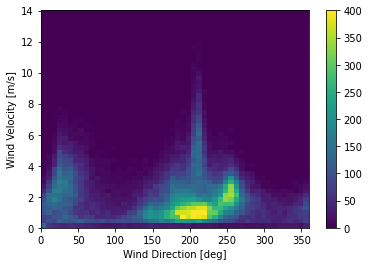

--------------------------------------------------
Working with wind vectors


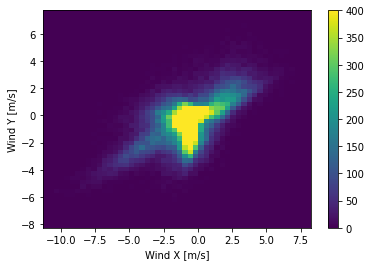

In [ ]:
# Wind : Wd degrees from 0 to 360 egrees
# Angles do not make good models inputs because 0 and 360 should be "close"

print('-'*50)
print("Working with angles...")

plt.hist2d(df['wd (deg)'], df['wv (m/s)'], 
           bins=(50, 50), 
           vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
plt.show()

# It is much easier for the model to interpret
# the wind direction and the wind velocity through a vector


# Convert degrees to radians and store the values into wd_rad
# $CHALLENGIFY_BEGIN
wd_rad = df.pop('wd (deg)')*np.pi / 180
# $CHALLENGIFY_END

# Calculate the wind x and y components and store then in two new columns
# `Wx` and `Wy`
# $CHALLENGIFY_BEGIN
wv = df.pop('wv (m/s)')
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)
# $CHALLENGIFY_END

# Calculate the max wind x and y components and store then in two new columns
# `max Wx` and `max Wy`
# $CHALLENGIFY_BEGIN
max_wv = df.pop('max. wv (m/s)')
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)
# $CHALLENGIFY_END

print('-'*50)
print("Working with wind vectors")

plt.hist2d(df['Wx'], df['Wy'], 
           bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')
plt.show()

# $CHALLENGIFY_END

In [ ]:
# Similarly to the wind direction, the time in seconds is not a useful model input
# The weather dataset has clear daily and yearly periodicities
# Using sine and cosine functions, we can compute:
# - the time of the day
# - the time of the year

# $CHALLENGIFY_BEGIN

# Collecting the timestamps
datetime_df = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamps_s = datetime_df.map(pd.Timestamp.timestamp)
timestamps_s

# 24 hours x 60 minutes/hour x 60 seconds/minute
day = 24*60*60 
# 1 year in days
year = (365.2425)*day

# Day periodicity
df['Day_sin'] = np.sin(timestamps_s * (2 * np.pi / day))
df['Day_cos'] = np.cos(timestamps_s * (2 * np.pi / day))

# Year periodicity
df['Year_sin'] = np.sin(timestamps_s * (2 * np.pi / year))
df['Year_cos'] = np.cos(timestamps_s * (2 * np.pi / year))

# $CHALLENGIFY_END

In [ ]:
# Select every 3 hours 

# $CHALLENGIFY_BEGIN
df = df[2::3].reset_index(drop = True)
df
# $CHALLENGIFY_END

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day_sin,Day_cos,Year_sin,Year_cos
0,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,7.071068e-01,7.071068e-01,0.011483,0.999934
1,997.71,-9.67,263.66,-10.62,92.70,2.93,2.71,0.21,1.69,2.72,1317.71,-0.041452,0.027960,-0.414519,0.279596,1.000000e+00,4.339955e-12,0.013633,0.999907
2,999.69,-7.66,265.52,-8.84,91.20,3.43,3.13,0.30,1.95,3.13,1310.14,-0.314796,-0.128466,-0.583298,-0.238040,7.071068e-01,-7.071068e-01,0.015783,0.999875
3,1000.30,-6.87,266.27,-8.28,89.60,3.64,3.27,0.38,2.03,3.26,1306.98,-1.834577,-0.141163,-2.622249,-0.201771,6.903299e-12,-1.000000e+00,0.017933,0.999839
4,999.88,-5.69,267.48,-7.00,90.40,3.99,3.61,0.38,2.25,3.61,1300.51,-0.825870,0.828758,-1.327039,1.331679,-7.071068e-01,-7.071068e-01,0.020083,0.999798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23358,1006.23,-6.31,266.37,-8.42,84.90,3.81,3.23,0.57,2.00,3.21,1312.01,-1.279930,-0.013404,-1.839899,-0.019268,6.755902e-01,-7.372773e-01,-0.000268,1.000000
23359,1004.62,-0.71,272.09,-5.97,67.37,5.80,3.91,1.89,2.42,3.89,1282.65,-0.976457,-0.412471,-1.916066,-0.809378,-4.361939e-02,-9.990482e-01,0.001883,0.999998
23360,1003.09,4.97,277.88,-3.04,56.03,8.71,4.88,3.83,3.03,4.86,1254.09,-0.403185,-0.359224,-0.776504,-0.691840,-7.372773e-01,-6.755902e-01,0.004033,0.999992
23361,1002.27,-0.42,272.56,-4.92,71.50,5.92,4.23,1.69,2.63,4.22,1278.14,-0.266024,-0.350473,-0.604599,-0.796530,-9.990482e-01,4.361939e-02,0.006183,0.999981


##### Trust us and start from this already preprocessed dataset for this challenge

In [ ]:
url = "https://wagon-public-datasets.s3.amazonaws.com/deep_learning_datasets/weather_every_three_hours_engineered.csv"
df = pd.read_csv(url).drop(columns = ['Unnamed: 0'])
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day_sin,Day_cos,Year_sin,Year_cos
0,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,7.071068e-01,7.071068e-01,0.011483,0.999934
1,997.71,-9.67,263.66,-10.62,92.70,2.93,2.71,0.21,1.69,2.72,1317.71,-0.041452,0.027960,-0.414519,0.279596,1.000000e+00,4.339955e-12,0.013633,0.999907
2,999.69,-7.66,265.52,-8.84,91.20,3.43,3.13,0.30,1.95,3.13,1310.14,-0.314796,-0.128466,-0.583298,-0.238040,7.071068e-01,-7.071068e-01,0.015783,0.999875
3,1000.30,-6.87,266.27,-8.28,89.60,3.64,3.27,0.38,2.03,3.26,1306.98,-1.834577,-0.141163,-2.622249,-0.201771,6.903299e-12,-1.000000e+00,0.017933,0.999839
4,999.88,-5.69,267.48,-7.00,90.40,3.99,3.61,0.38,2.25,3.61,1300.51,-0.825870,0.828758,-1.327039,1.331679,-7.071068e-01,-7.071068e-01,0.020083,0.999798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23358,1006.23,-6.31,266.37,-8.42,84.90,3.81,3.23,0.57,2.00,3.21,1312.01,-1.279930,-0.013404,-1.839899,-0.019268,6.755902e-01,-7.372773e-01,-0.000268,1.000000
23359,1004.62,-0.71,272.09,-5.97,67.37,5.80,3.91,1.89,2.42,3.89,1282.65,-0.976457,-0.412471,-1.916066,-0.809378,-4.361939e-02,-9.990482e-01,0.001883,0.999998
23360,1003.09,4.97,277.88,-3.04,56.03,8.71,4.88,3.83,3.03,4.86,1254.09,-0.403185,-0.359224,-0.776504,-0.691840,-7.372773e-01,-6.755902e-01,0.004033,0.999992
23361,1002.27,-0.42,272.56,-4.92,71.50,5.92,4.23,1.69,2.63,4.22,1278.14,-0.266024,-0.350473,-0.604599,-0.796530,-9.990482e-01,4.361939e-02,0.006183,0.999981


👆 In the preprocessed dataset, we have :
- $23$k rows  (~ 8 years of weather data)
- $19$ features composed of:
    - $1$ <font color=green>**target**</font> (we will use the past values of the temperature as a feature)
    - $18$ <font color=orange>**past covariates**</font> (= features which past values are known)
    - $0$ <font color=blue>**future covariates**</font> (= features which future values are known, e.g. public holidays)

    
<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/DL/time-series-covariates.png'>

👨🏻‍🏫 This weather dataset is a DataFrame (dimension = 2) which is a single Time Series from the beginning of 2009 to the end 2016 with records every 3 hours. 

* `df.shape = (n_timesteps, n_features) = (23363, 19)`

🎯 The goal is to predict the temperature in 3, 6, 9, 12, ... hours using the past values.

In [ ]:
# Let's define the global variables of our dataset
TARGET = 'T (degC)'
N_TARGETS = 1
N_FEATURES = 19

### (0.0.2) Visualising your Time Series

📈  Here is the ***evolution of some features over time***:
* `T (degC)` (temperature)
* `p (mbar)` (atmospheric pressure)
* `rho (g/m**3)` (atmospheric density)



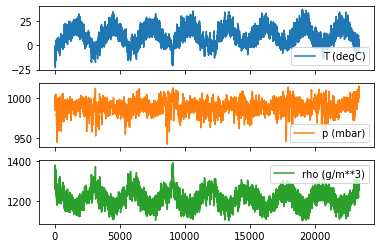

In [ ]:
plot_cols = [TARGET, 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = df.index
plot_features.plot(subplots = True);

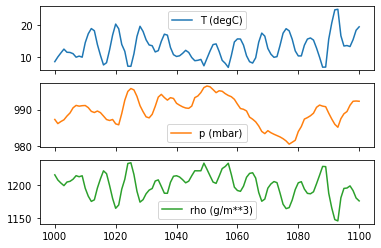

In [ ]:
zoomed_slice = slice(1000,1100)

plot_features = df.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

# (1) Prepare the dataset

##  (1.0) The big picture

<b><u>Step 1: Cross-Validation in Time Series [FOLDS] </u></b>

* Starting from this single Time Series, we will create <font color="#c91ac9">**FOLDS**</font>...
* ... and train/evaluate our LSTM on these different <font color="#c91ac9">**FOLDS**</font> to conclude about the robustness of the neural network
* It is very common to create ***hundreds*** of <font color="#c91ac9">**FOLDS**</font> in Time Series forecasting, in order to to cover all types of external conditions: e.g.
    - crash market periods 📉
    - bull markets 📈
    - atone markets 😴, etc...

<b><u>Step 2: Holdout method within each fold [TRAIN-TEST SPLIT]</u></b>

* For each <font color="#c91ac9">**FOLD**</font>, we will do a TRAIN-TEST SPLIT to:
    * <font color=blue>**fit**</font> the model on the <font color=blue>**train**</font> set 
    * and <font color="#ff8005">**evaluate**</font> it on the <font color="#ff8005">**test**</font> set
    * Always split the train set **chronologically** before the test set!

👇 The first two steps can be summarized in the following image that contains 4 FOLDS:

<img src="https://bit.ly/3yLoa92" alt="Time Series Cross Validation" width="500" height="500">


<b><u>Step 3: Sampling SEQUENCES in both the train set and the test set</u></b>

In each <font color=blue>**train**</font> set and each <font color="#ff8005">**test**</font> set, we will create <font color=magenta>**random sequences**</font> as illustrated down below 👇:

<img src="https://bit.ly/3Ri8Vfd" alt="Sequences in each fold" width="500" height="500"> 



## (1.1) Creating  <font color="#c91ac9">**FOLDS**</font> for cross-validation

Each of them with shape `(FOLD_LENGTH, n_features)` 

🌐 Let's define some global variables that we will use for our tests everywhere in this notebook:

In [ ]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 8*365 * 3 # every 3 hrs x 8 = 24h
                        # three years

# --------------------------------------------------- #
# Let's consider FOLDS starting every trimester       #
# --------------------------------------------------- #
    
FOLD_STRIDE = 8*91 # every 3 hrs x 8 = 24h
                   # 1 quarter = 91 days

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66

❓ **Question (<font color="#c91ac9">FOLDS</font>)** ❓

Code the function `get_folds` below that we will use to create folds  `folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)`

In [ ]:
def get_folds(
    df: pd.DataFrame, 
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    # $CHALLENGIFY_BEGIN
    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds
    # $CHALLENGIFY_END

🧪 ***Test your code***

In [ ]:
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 21 folds.
Each fold has a shape equal to (8760, 19).


In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult('folds',
                         number_of_folds = len(folds),
                         fold_shape = folds[0].shape)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/davywai/.pyenv/versions/lewagon_data_staff/bin/python3
cachedir: .pytest_cache
rootdir: /Users/davywai/code/lewagon/data-solutions/06-Deep-Learning/04-Recurrent-Neural-Networks/03-Predict-temperature
plugins: anyio-3.4.0
collecting ... collected 2 items

tests/test_folds.py::TestFolds::test_variable_fold_shape PASSED          [ 50%]
tests/test_folds.py::TestFolds::test_variable_number_of_folds PASSED     [100%]

============================== 2 passed in 0.03s ===============================


💯 You can commit your code:

git add tests/folds.pickle

git commit -m 'Completed folds step'

git push origin master


☝️ This amount of <font color="#c91ac9">**FOLDS**</font> should be enough to cross-validate our model correctly !

## (1.2) Temporal <font color=blue>**Train**</font>/<font color="#ff8005">**Test**</font> Split

👩🏻‍🏫 Let's focus on one fold for the moment.

In [ ]:
fold = folds[0]
fold

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day_sin,Day_cos,Year_sin,Year_cos
0,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,7.071068e-01,7.071068e-01,0.011483,0.999934
1,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,-0.041452,0.027960,-0.414519,0.279596,1.000000e+00,4.339955e-12,0.013633,0.999907
2,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,-0.314796,-0.128466,-0.583298,-0.238040,7.071068e-01,-7.071068e-01,0.015783,0.999875
3,1000.30,-6.87,266.27,-8.28,89.6,3.64,3.27,0.38,2.03,3.26,1306.98,-1.834577,-0.141163,-2.622249,-0.201771,6.903299e-12,-1.000000e+00,0.017933,0.999839
4,999.88,-5.69,267.48,-7.00,90.4,3.99,3.61,0.38,2.25,3.61,1300.51,-0.825870,0.828758,-1.327039,1.331679,-7.071068e-01,-7.071068e-01,0.020083,0.999798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,980.34,1.45,276.18,0.03,90.2,6.79,6.12,0.67,3.89,6.24,1240.67,-0.604351,-3.731375,-1.191115,-7.354165,-8.715574e-02,-9.961947e-01,-0.028744,0.999587
8756,983.25,2.23,276.73,0.21,86.4,7.18,6.20,0.98,3.93,6.31,1240.81,-0.432628,-2.126437,-0.849307,-4.174479,-7.660444e-01,-6.427876e-01,-0.026594,0.999646
8757,985.46,1.69,276.00,-0.52,85.2,6.90,5.88,1.02,3.72,5.97,1246.23,-0.626578,-2.513066,-0.977364,-3.919995,-9.961947e-01,8.715574e-02,-0.024445,0.999701
8758,986.63,2.16,276.38,-1.14,78.7,7.14,5.62,1.52,3.55,5.70,1245.68,-0.773266,-3.669409,-1.222791,-5.802558,-6.427876e-01,7.660444e-01,-0.022295,0.999751


☝️ We want to split this fold **chronologically** into:

- a <font color=blue>train</font> dataframe
- a <font color="#ff8005">test</font> dataframe

that will contain all the data we need to be able to sample many `(X_i, y_i)` pairs in each dataframe in a next step! 

The `INPUT_LENGTH` of each `X_i` is going to be equal to 2 weeks (it is quite a common period for weather forecasting)

In [ ]:
INPUT_LENGTH = 8 * 14 # records every 3 hours x 8 = 24 hours
                      # two weeks

❓ **Question (temporal <font color=blue>train</font>-<font color=orange>test</font> split)** ❓

Code the function `train_test_split` down below which:
- <i>(input)</i> given a `fold` (like above), a `train_test_ratio` (e.g 0.8) and an `input_length` (fixed)
- <i>(output)</i> a tuple of (`fold_train`, `fold_test`) dataframes


❗️Hints to avoid data leakage❗️ 

- `fold_train` last index will become the last `y_train` later on
- `fold_test` first index will be used to create the first `X_test`
- To avoid data leakage, `y_train_last` should be JUST before `y_test_first`

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/DL/explanations_for_train_test_split_temporal.png" alt="train_test_split_temporal" width="500" height="500"> 

In [ ]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    # $CHALLENGIFY_BEGIN
    
    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    # ======================    
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)
    # $CHALLENGIFY_END

🧪 ***Test your code***

In [ ]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult('holdout',
                         train_index_start = fold_train.index.start,
                         train_index_stop = fold_train.index.stop,
                         test_index_start = fold_test.index.start,
                         test_index_stop = fold_test.index.stop)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/davywai/.pyenv/versions/lewagon_data_staff/bin/python3
cachedir: .pytest_cache
rootdir: /Users/davywai/code/lewagon/data-solutions/06-Deep-Learning/04-Recurrent-Neural-Networks/03-Predict-temperature
plugins: anyio-3.4.0
collecting ... collected 4 items

tests/test_holdout.py::TestHoldout::test_variable_test_index_start PASSED [ 25%]
tests/test_holdout.py::TestHoldout::test_variable_test_index_stop PASSED [ 50%]
tests/test_holdout.py::TestHoldout::test_variable_train_index_start PASSED [ 75%]
tests/test_holdout.py::TestHoldout::test_variable_train_index_stop PASSED [100%]

============================== 4 passed in 0.03s ===============================


💯 You can commit your code:

git add tests/holdout.pickle

git commit -m 'Completed holdout step'

git push origin master


## (1.3) Create (X, y) sequences

Now that we have splitted our fold into a <font color="blue">train</font> set and a <font color="#ff8005">test</font> set, it is time to:
- 🏋 sample lots of sequences $(X_i, y_i)$ on which the model will be <font color="blue">trained</font>
- 👩🏻‍🏫 sample lots of sequences $(X_i, y_i)$ on which the model will be <font color="#ff8005">evaluated</font>

<img src="https://bit.ly/3Ri8Vfd" alt="Sequences in each fold" width="300" height="300"> 

🎯 Our goal is to create 3D-arrays `(X_train, y_train)` and `(X_test, y_test)` containing all the SEQUENCES we need from this fold:

* `X_train.shape = (n_samples_train, input_length, n_features)`
* `y_train.shape = (n_samples_train, output_length, n_targets)`

👉 Notice that we are now dealing with **3D arrays** instead of **2D DataFrames** time-series

<img src="https://bit.ly/3bOhKNj" alt="3d arrays time series" width="1200" height="800"> 

In [ ]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH}')

N_FEATURES = 19
INPUT_LENGTH = 112


☝️ `X` is the **input** of our model. 
- It contains $19$ features: the past values of the <font color=green>**target**</font> + $18$ <font color=orange>**past-covariates**</font>
- Each sequence has a length equal to $112$ timesteps (=$2$ weeks)

In [ ]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1

N_TARGETS = 1


☝️ `y` is the <font color=green>**target**</font> that we want to predic:t
- It is the value at the single next timestep (=3 hours later)
- We could also predict `OUTPUT_LENGTH > 1`, i.e several values in the future (3 hours later, 6 hours later, 9 hours later, ...) but let's keep it simple here and just try to predict the next point (in 3 hours)

💡 To create these SEQUENCES within the <font color="blue">train</font> set and the <font color="#ff8005">test</font> set, you have several options, among them:
- 🎲 <u><i>Option 1</i></u>: creating these sequences by randomly sampling $(X_i, y_i)$ from <font color="blue">fold_train</font> and <font color="#ff8005">fold_test</font>.
- ⌚️ <u><i>Option 2</i></u>: scanning a fold chronologically and create all the possible pairs $(X_i, y_i)$. 
 

👉 Let's focus on the first option: random sampling

🎁 If you want to scan the folds chronologically, we provided the solution in the section and you can come back to it later


### (1.2.1) Option 1: Create (X, y) by random sampling in each split

👇 We will code:

* 1️⃣ a function `get_Xi_yi` to generate a single sequence randomly from within a fold

* 2️⃣ a function `get_X_y` to generate 3D-arrays containing multiple sequences from a fold, calling the first function `get_Xi_yi` many times over

#### (1.2.2.1) Generating one random sequence

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/DL/get_xi_yi.png" alt="one sequence" width="400" height="400"> 

❓ **Question (extracting a random sequence from a fold)** ❓

Code the function `get_Xi_yi` down below which:
- <i>(input)</i> given a fold, an `input_length` and an `output_length`
- <i>(output)</i> returns a sequence $(X_i,y_i)$

In [ ]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    # $CHALLENGIFY_BEGIN
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]    
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]
    
    return (X_i, y_i)
    # $CHALLENGIFY_END

🧪 ***Test your code below***

In [ ]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult('sequence',
                         x_train_i_shape = X_train_i.shape,
                         y_train_i_shape = y_train_i.shape,
                         x_test_i_shape = X_test_i.shape,
                         y_test_i_shape = y_test_i.shape)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/davywai/.pyenv/versions/lewagon_data_staff/bin/python3
cachedir: .pytest_cache
rootdir: /Users/davywai/code/lewagon/data-solutions/06-Deep-Learning/04-Recurrent-Neural-Networks/03-Predict-temperature
plugins: anyio-3.4.0
collecting ... collected 4 items

tests/test_sequence.py::TestSequence::test_variable_x_test_i_shape PASSED [ 25%]
tests/test_sequence.py::TestSequence::test_variable_x_train_i_shape PASSED [ 50%]
tests/test_sequence.py::TestSequence::test_variable_y_test_i_shape PASSED [ 75%]
tests/test_sequence.py::TestSequence::test_variable_y_train_i_shape PASSED [100%]

============================== 4 passed in 0.04s ===============================


💯 You can commit your code:

git add tests/sequence.pickle

git commit -m 'Completed sequence step'

git push origin master


In [ ]:
# Advanced check 😈 
# You should not allow some truncated (X_i,y_i) pairs to be generating,
# should you start sampling too close from the end of the fold... !

X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

#### (1.2.2.2) Generating multiple random sequences

<img src="https://bit.ly/3Ri8Vfd" alt="Sequences in each fold" width="500" height="500"> 

❓ **Question (extracting multiple random sequence from a fold)** ❓

Code the function `get_X_y` down below which:
- <i>(input)</i> given a fold, a `number_of_sequences` an `input_length` and an `output_length`
- <i>(output)</i> returns $(X,y)$ 

_Don't forget to use the `get_Xi_yi` function that you have just coded!_

In [ ]:
def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int
):
    # $CHALLENGIFY_BEGIN    
    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)
        
    return np.array(X), np.array(y)
    # $CHALLENGIFY_END

🧪 ***Test your code***

In [ ]:
N_TRAIN = 6666 # number_of_sequences_train
N_TEST =  3333 # number_of_sequences_test

X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult('multiple_sequences',
                         x_train_shape = X_train.shape,
                         y_train_shape = y_train.shape,
                         x_test_shape = X_test.shape,
                         y_test_shape = y_test.shape)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/davywai/.pyenv/versions/lewagon_data_staff/bin/python3
cachedir: .pytest_cache
rootdir: /Users/davywai/code/lewagon/data-solutions/06-Deep-Learning/04-Recurrent-Neural-Networks/03-Predict-temperature
plugins: anyio-3.4.0
collecting ... collected 4 items

tests/test_multiple_sequences.py::TestMultipleSequences::test_variable_x_test_i_shape PASSED [ 25%]
tests/test_multiple_sequences.py::TestMultipleSequences::test_variable_x_train_shape PASSED [ 50%]
tests/test_multiple_sequences.py::TestMultipleSequences::test_variable_y_test_i_shape PASSED [ 75%]
tests/test_multiple_sequences.py::TestMultipleSequences::test_variable_y_train_shape PASSED [100%]

============================== 4 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/multiple_sequences.pickle

git commit -m 'Completed multi

### (1.2.2) (Don't read this now, keep for later) 🎁 Option 2: Scanning  chronologically

As stated earlier, there are multiple ways to extract sequences from a fold. 

- 🎲 In the previous section, you coded:
    - `get_Xi_yi` which randomly samples _one_ sequence 
    - and `get_X_y` which randomly generates _multiple_ sequences

- ⌚️ In this section, we provide you a unique function `get_X_y_strides`.
    - It scans a fold chronologically based on:
         - an `input_length` (let's still use `INPUT_LENGTH = 8 * 14`, i.e. two weeks) 
         - and a `sequence_stride` (think about a one-dimensional convolutional operation!)

👉 Let's scan the fold with a temporal stride of 3 hours (the minimum one):

In [ ]:
SEQUENCE_STRIDE = 1

In [ ]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) > len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

🧑🏻‍🎓 Some clarifications about scanning a fold sequentially :

In [ ]:
print("FOLD_LENGTH") 
print(f"= {FOLD_LENGTH} timesteps")
print(f"= {int(FOLD_LENGTH/8)} days") # 8 records per day, every 3 hours
print(f"= {int(FOLD_LENGTH/8/7)} weeks")

FOLD_LENGTH
= 8760 timesteps
= 1095 days
= 156 weeks


In [ ]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(5670, 112, 19)
(5670, 1, 1)


👇 Illustration down below if *SEQUENCE_STRIDE = 1 week*

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/DL/scanning_a_time_series_chronologically_v3.png">

# (2) Modelling

**The MAE as a metrics to monitor the temperature prediction**

The Mean Absolute Error seems to be a reasonable metrics to evaluate a model's capability to predict the temperature:

$$ MAE = \frac{1}{n_{samples}} \times \sum_{i = 1}^{n_{samples}} |y_{true}^{(i)} - y_{pred}^{(i)}|$$

## (2.1) A Recurrent Neural Network: the `LSTM`

🚀 It is time to design a Recurrent Neural Network and hopefully beat the baseline 💪 !

❓ **Question (RNN)** ❓ 

- Create a function `init_model` which builds and compiles a simple Recurrent Neural Network with an LSTM layer
- Don't forget to normalize your data with a [📚 Normalization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization

def init_model(X_train, y_train):
    
    # $CHALLENGIFY_BEGIN    
    
    # 0 - Normalization
    # ======================    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences = False,
                          recurrent_dropout = 0.3))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.02)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model
    # $CHALLENGIFY_END

In [ ]:
model = init_model(X_train, y_train)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, None, 19)         39        
 ion)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 64)                21504     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21,608
Trainable params: 21,569
Non-trainable params: 39
_________________________________________________________________


🛠 🎁 📉 We coded a function `plot_history` for you to visualize the training of your RNN over epochs. This function shows both the evolution of the loss function (MSE) and metrics (MAE).

In [ ]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

❓ **Questions (training and evaluating)** ❓

- Code the `fit_model()` method that 
    - <i>(input)</i> given `model`
    - <i>(output)</i> returns the fitted model through a tuple `(model, history)` 
- Then:
    - Initialize an RNN model with the `init_model` function
    - <font color=blue>Train</font> the model
    - <font color=orange>Evaluate</font> it on the test set

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    # $CHALLENGIFY_BEGIN
    es = EarlyStopping(monitor = "val_loss",
                      patience = 3,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [es],
                        verbose = verbose)

    return model, history
    # $CHALLENGIFY_END

In [ ]:
# 1 - Initialising the RNN model
# ====================================

model = init_model(X_train, y_train)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, None, 19)         39        
 ion)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 64)                21504     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21,608
Trainable params: 21,569
Non-trainable params: 39
_________________________________________________________________
Epoch 1/50
146/146 [==============================] - 9s 55ms/step - loss: 9.6145 - mae: 1.9985 - val_loss: 2.9534 - val_mae: 1.3244
Epoch 2/50
146/146 [==============================] - 8s 56ms/step - loss: 2.9796 - mae: 1.3154 - val_loss: 2.4169

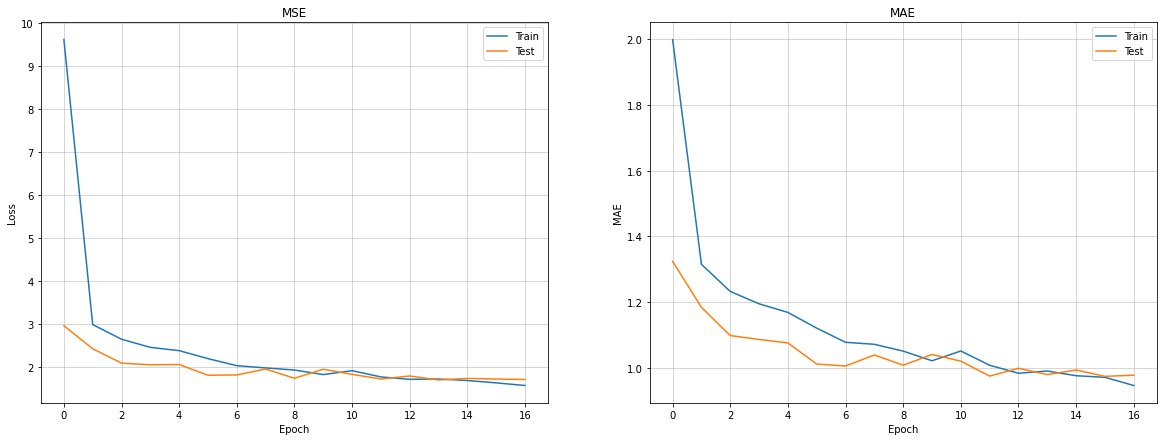

In [ ]:
plot_history(history);

In [ ]:
# 3 - Evaluation
# ====================================
res = model.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} Celsius degrees")

105/105 [==============================] - 1s 10ms/step - loss: 2.9790 - mae: 1.2820
The LSTM MAE on the test set is equal to 1.28 Celsius degrees


## (2.2) A Baseline Model to compare our LSTM with!

👉 In Time Series, an "intuitive" baseline model is to predict the **last seen value** for the future value(s) you want to forecast, as illustrated down below!

<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/DL/rnn_time_series_no_horizon.png" width = 600, height = 300>

❓ **Question (Last Seen Value Baseline Model)** ❓ 

Create a new method `init_baseline` that initializes and compiles a baseline model in a similar way to the LSTM.

- The baseline should be as a [📚 Keras Lambda Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda)
- It should not even need a `fit` because it should have 0 trainable params
- Then, compute the MAE for this FOLD and compare it with the MAE you obtained on the test set after training the LSTM 
 
<details>
    <summary markdown='span'>💡 <i>Hint</i></summary>

- Remember that `X_train[:,:,1]` is your temperature time-series (it's the second column in your `fold`) 
</details>


In [ ]:
from tensorflow.keras.layers import Lambda

def init_baseline():

    # $CHALLENGIFY_BEGIN
    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x[:,-1,1,None]))

    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model
    # $CHALLENGIFY_END

In [ ]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],2)} Celsius degrees")

105/105 [==============================] - 0s 707us/step - loss: 7.9189 - mae: 2.0500
- The Baseline MAE on the test set is equal to 2.05 Celsius degrees


In [ ]:
print(f"- The LSTM MAE on the test set is equal to {round(res[1],2)} Celsius degrees")
print(f"🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/baseline_score[1]))*100,2)} % 🔥")

- The LSTM MAE on the test set is equal to 1.28 Celsius degrees
🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : 37.46 % 🔥


## (2.3) Cross-Validation

Remember **"The big picture"** ? 

<br>

<details>
    <summary markdown='span'><i>The big picture</i></summary>


<b><u>Step 1: Cross-Validation in Time Series [FOLDS] </u></b>

* Starting from this single Time Series, we will create <font color="#c91ac9">**FOLDS**</font>...
* ... and train/evaluate our LSTM on these different <font color="#c91ac9">**FOLDS**</font> to conclude about the robustness of the neural network
* It is very common to create ***hundreds*** of <font color="#c91ac9">**FOLDS**</font> in Time Series forecasting, so as to cover all type of external conditions: e.g.
    - crash market periods 📉
    - bull markets 📈
    - atone markets 😴, etc...

<b><u>Step 2: Holdout method within each fold [TRAIN-TEST SPLIT]</u></b>

* For each <font color="#c91ac9">**FOLD**</font>, we will do a TRAIN-TEST SPLIT to:
    * <font color=blue>**fit**</font> the model on the <font color=blue>**train**</font> set 
    * and <font color="#ff8005">**evaluate**</font> it on the <font color="#ff8005">**test**</font> set
    * Always split the train set **chronologically** before the test set!

👇 The first two steps can be summarized in the following image that contains 4 FOLDS:

<img src="https://bit.ly/3yLoa92" alt="Time Series Cross Validation" width="500" height="500">


<b><u>Step 3: Sampling SEQUENCES in both the train set and the test set</u></b>

In each <font color=blue>**train**</font> set and each <font color="#ff8005">**test**</font> set, we will create <font color=magenta>**random sequences**</font> as illustrated down below 👇:

<img src="https://bit.ly/3Ri8Vfd" alt="Sequences in each fold" width="500" height="500"> 


</details>

❗️ ***Warnings*** ❗️

* Keep in mind that we did <u><i>step 2</i></u> (<font color="blue">train</font>/<font color="orange">test</font> split) and <u><i>step 3</i></u> (get_X_y) only **<font color="#c91ac9">for one single FOLD</font>**. 
* ***If we want to ensure the robustness of a model, we need to <font color="">cross-validate the model on <font color="#c91ac9">ALL the folds</font>!***


In [ ]:
# Reminders of the global variables in this notebook

print(f'N_FEATURES = {N_FEATURES}') 
print(f'N_TARGETS = {N_TARGETS}') 
print('')
print(f'FOLD_LENGTH = {FOLD_LENGTH}')
print(f'FOLD_STRIDE = {FOLD_STRIDE}')
print(f'TRAIN_TEST_RATIO = {TRAIN_TEST_RATIO}')
print('')
print(f'N_TRAIN = {N_TRAIN}')
print(f'N_TEST = {N_TEST}')
print(f'INPUT_LENGTH = {INPUT_LENGTH}')
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')


N_FEATURES = 19
N_TARGETS = 1

FOLD_LENGTH = 8760
FOLD_STRIDE = 728
TRAIN_TEST_RATIO = 0.66

N_TRAIN = 6666
N_TEST = 3333
INPUT_LENGTH = 112
OUTPUT_LENGTH = 1


In [ ]:
# Remember how many folds do we have ?
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)

print(f"WARNING, we have {len(folds)} FOLDS, so you may want to run the cross-validation of the RNN on Colab.")

WARNING, we have 21 FOLDS, so you may want to run the cross-validation of the RNN on Colab...


**❓ Cross validate your baseline and your model in a for-loop!❓**

Re-using your previously defined methods
- `get_folds`
- `train_test_split`
- `get_X_y`
- `init_model`
- `init_baseline`

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def cross_validate_baseline_and_lstm():
    '''
    This function cross-validates 
    - the "last seen value" baseline model
    - the RNN model
    '''
    
    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []
    
    # 0 - Creating folds
    # =========================================    
    folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)
    
    for fold_id, fold in enumerate(folds):
        
        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)                   

        X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
        X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)
        
        # 2 - Modelling
        # =========================================
        
        ##### Baseline Model
        baseline_model = init_baseline()
        mae_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)[1]
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train, y_train)
        es = EarlyStopping(monitor = "val_mae",
                           mode = "min",
                           patience = 2, 
                           restore_best_weights = True)
        history = model.fit(X_train, y_train,
                            validation_split = 0.3,
                            shuffle = False,
                            batch_size = 32,
                            epochs = 50,
                            callbacks = [es],
                            verbose = 0)
        res = model.evaluate(X_test, y_test, verbose=0)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")
        
        ##### Comparison LSTM vs Baseline for the current fold
        print(f"🏋🏽‍♂️ improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model

In [ ]:
%%time
# WARNING : it takes 75 minutes to run this cell 
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()

--------------------------------------------------
MAE baseline fold n°0 = 2.09
MAE LSTM fold n°0 = 1.3
🏋🏽‍♂️ improvement over baseline: 37.87 % 

--------------------------------------------------
MAE baseline fold n°1 = 2.06
MAE LSTM fold n°1 = 1.28
🏋🏽‍♂️ improvement over baseline: 37.89 % 

--------------------------------------------------
MAE baseline fold n°2 = 1.91
MAE LSTM fold n°2 = 1.29
🏋🏽‍♂️ improvement over baseline: 32.34 % 

--------------------------------------------------
MAE baseline fold n°3 = 1.96
MAE LSTM fold n°3 = 1.28
🏋🏽‍♂️ improvement over baseline: 34.98 % 

--------------------------------------------------
MAE baseline fold n°4 = 1.91
MAE LSTM fold n°4 = 1.36
🏋🏽‍♂️ improvement over baseline: 29.0 % 

--------------------------------------------------
MAE baseline fold n°5 = 1.79
MAE LSTM fold n°5 = 1.16
🏋🏽‍♂️ improvement over baseline: 35.45 % 

--------------------------------------------------
MAE baseline fold n°6 = 1.7
MAE LSTM fold n°6 = 1.23
🏋🏽‍♂️ impr

In [ ]:
print(f"average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")

average percentage improvement over baseline = 34.0%


## Acknowledgments

* This challenge was truly inspired by the `Time Series Forecasting` tutorial from `Google>Tensorflow>Keras`
* The technical functions were inspired by Bruno Lajoie's [data-template package about Time Series](https://github.com/lewagon/data-templates/tree/main/project-boilerplates)